with_torch_1 에서 안정적으로 확장, L_BFGS와 Adam함께 이용하기 

In [2]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm

import torch
import torch.nn as nn
from torchsummary import summary

In [2]:
# Multi-layer Perceptron
class NN(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        act=torch.nn.Tanh,
    ):
        super(NN, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth): 
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [3]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN(
            input_size=2,
            hidden_size=20,
            output_size=1,
            depth=4,
            act=torch.nn.Tanh
        ).to(device)
        
        # 간격
        self.h = 0.1
        self.k = 0.1
        # (x,y) 좌표점
        x = torch.arange(-np.pi, np.pi + self.h, self.h)
        y = torch.arange(-np.pi, np.pi + self.k, self.k)
        self.X = torch.stack(torch.meshgrid(x, y)).reshape(2, -1).T
        
        # Pred BC
        bc1 = torch.stack(torch.meshgrid(x[0], y)).reshape(2, -1).T  # Left BC
        bc2 = torch.stack(torch.meshgrid(x[-1], y)).reshape(2, -1).T # Right BC
        self.X_train = torch.cat([bc1, bc2])
        
        # True BC
        f_bc1 = torch.zeros(len(bc1))
        f_bc2 = torch.zeros(len(bc2))
        self.f_train = torch.cat([f_bc1, f_bc2])
        self.f_train = self.f_train.unsqueeze(1)
        
        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.f_train = self.f_train.to(device)
        self.X.requires_grad = True
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",   # better numerical stability
        )
        
        self.adam = torch.optim.Adam(self.model.parameters())
        
    def loss_func(self):
        
        # 초기화
        self.adam.zero_grad()
        self.optimizer.zero_grad()
        
        f_pred = self.model(self.X_train)
        loss_data = self.criterion(f_pred, self.f_train)
        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            inputs=self.X, 
            outputs=u, 
            grad_outputs=torch.ones_like(u), 
            retain_graph=True, 
            create_graph=True
        )[0]
        
        du_dx = du_dX[:, 0]
        du_dy = du_dX[:, 1]
        du_dXX = torch.autograd.grad(
            inputs=self.X, 
            outputs=du_dX, 
            grad_outputs=torch.ones_like(du_dX), 
            retain_graph=True, 
            create_graph=True
        )[0]
        
        du_dxx = du_dXX[:,0]
        du_dyy = du_dXX[:,1]
        
        loss_pde = self.criterion( du_dxx + du_dyy , -2*u.squeeze() )

        loss = loss_pde + loss_data
        loss.backward()
        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        return loss
    
    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)
        
    def eval_(self):
        self.model.eval()

In [4]:
net = Net()
net.train()

/usr/local/lib/python3.8/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 1.763181535352487e-05
200 7.361742518696701e-06
300 3.0789633456151932e-06
400 1.4517830777549534e-06
500 8.717561286175624e-07
600 6.133168426458724e-07
700 4.707246716861846e-07
800 3.8423326031988836e-07
900 3.2772243230283493e-07
1000 2.875720497286238e-07
1100 2.8816594976888155e-07
1200 2.8795898288080934e-07
1300 2.8736118906635966e-07
1400 2.8710326205327874e-07
1500 2.869249726700218e-07
1600 2.865221517822647e-07
1700 2.863030488242657e-07
1800 2.8615633596018597e-07
1900 2.860080030586687e-07
2000 2.856168919151969e-07
2100 2.855137779533834e-07
2200 2.8535714591271244e-07
2300 2.8521256467684e-07
2400 2.850960356681753e-07
2500 2.849515112757217e-07
2600 2.8480852165557735e-07
2700 2.846533107003779e-07
2800 2.8452080869101337e-07
2900 2.843938773366972e-07
3000 2.8425830578271416e-07
3100 2.8412202368599537e-07
3200 2.840805564119364e-07
3300 2.8388529926814954e-07
3400 2.837933550381422e-07
3500 2.8365835191834776e-07
3600 2.8353747438814025e-07
3700 2.834626968706288

In [20]:
# net.eval_()
net.model.eval()
h = 0.01
k = 0.01
x = torch.arange(-2*np.pi, 2*np.pi, h)
y = torch.arange(-2*np.pi, 2*np.pi, k)


# exact solution
X = torch.stack(torch.meshgrid(x, y)).reshape(2, -1).T
X = X.to(net.X.device)

In [21]:
model = net.model
model.eval()
with torch.no_grad():
    f_pred = model(X).reshape(len(x), len(y)).cpu().numpy()

In [22]:
f_pred.shape

(1257, 1257)

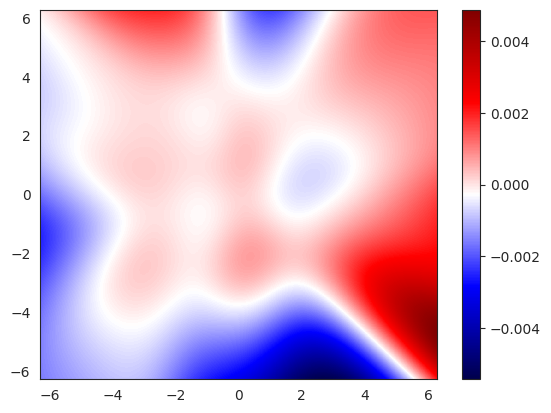

In [28]:
sns.set_style("white")
plt.pcolor(x, y, f_pred, cmap='seismic')
plt.colorbar()

In [35]:
x.shape, y.shape, f_pred.shape

(torch.Size([1257]), torch.Size([1257]), (1257, 1257))

In [37]:
x[0:10],y[0:10],f_test[:10],f_pred[0]

(tensor([-6.2832, -6.2732, -6.2632, -6.2532, -6.2432, -6.2332, -6.2232, -6.2132,
         -6.2032, -6.1932]),
 tensor([-6.2832, -6.2732, -6.2632, -6.2532, -6.2432, -6.2332, -6.2232, -6.2132,
         -6.2032, -6.1932]),
 tensor([3.0571e-14, 9.9998e-05, 3.9994e-04, 8.9973e-04, 1.5991e-03, 2.4979e-03,
         3.5957e-03, 4.8920e-03, 6.3864e-03, 8.0782e-03]),
 array([-0.00159896, -0.00159536, -0.00159173, ...,  0.00189022,
         0.00192319,  0.00195608], dtype=float32))

In [38]:
X = torch.stack(torch.meshgrid(x, y)).reshape(2, -1).T

tensor(-6.2832)
tensor(-6.2832)
